In [54]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import getpass
from shogun import *
from scripts import utils
from datetime import datetime, timedelta

import time

# below imports are used to print out pretty pandas dataframes
from IPython.display import display, HTML

#from xgboost import XGBClassifier

%matplotlib inline
plt.style.use('ggplot')

In [2]:
# SQL database config
sqluser = 'o4nguyen'
dbname = 'MIMIC3'
schema_name = 'mimiciii'
hostname = 'hdsldb.uwaterloo.ca'
port = 5432
pwd = getpass.getpass()

# Connect to local postgres version of mimic
con = psycopg2.connect(dbname=dbname, user=sqluser, host=hostname, port=5432, password=pwd)
cur = con.cursor()
cur.execute('SET search_path to ' + schema_name)

········


In [3]:
%%time
query_output = utils.get_query_from_file('sql/firstday-lagged-materialized.sql', con)
query_output.to_csv('./vitals-lagged.csv', index=False)

CPU times: user 1min 23s, sys: 8 s, total: 1min 31s
Wall time: 2min 57s


In [73]:
query_output = pd.read_csv('./vitals-lagged (copy).csv') #, index_col='timestamp') #.dropna().reset_index(drop=True)

query_output = query_output.dropna(subset=['timestamp'], how='any')
query_output= query_output.set_index('timestamp')

query_output.first_careunit = pd.Categorical(query_output.first_careunit)
query_output.gender = pd.Categorical(query_output.gender)
query_output.admission_type = pd.Categorical(query_output.admission_type)

query_output['gender'] = query_output.gender.cat.codes
query_output['first_careunit'] = query_output.first_careunit.cat.codes
query_output['admission_type'] = query_output.admission_type.cat.codes

query_output = query_output[(query_output.exclusion_los == 0) & (query_output.exclusion_age == 0) 
                            & (query_output.exclusion_first_stay == 0) ]#& (query_output.age_icu_in < 250)]

# Median age of patients > 89 is 91.6
query_output.loc[query_output.age_icu_in > 89, 'age_icu_in'] = 91.6

mortality_names = ['hospital_expire_flag', 'icu_expire_flag', 
                   'dod_hosp', 'dead_in_1d', 'dead_in_7d']

# Demographic information
demographics =  ['subject_id', 'age_icu_in', 'gender', 
                 'first_careunit', 'admission_type']

vital_signs = ['hr', 'diasbp', 'sysbp', 'meanbp', 'resprate', 'tempc', 'spo2']
features = [[v, v + '_mean_6h', v + '_median_6h', v + '_1h', v + '_max_6h', v + '_min_6h'] for v in vital_signs]
feature_names = []
for f in features:
    feature_names += f
    
feature_names[0] = 'heartrate'

query_output = query_output.loc[:, mortality_names + demographics + feature_names]
query_output = query_output.fillna(query_output.mean())
query_output.index = pd.to_datetime(query_output.index)

# Remove points after a patient has already died
will_die = (~query_output.dod_hosp.isnull())
point_after_dead = (query_output.index > pd.DatetimeIndex(query_output.dod_hosp))
query_output = query_output.loc[~(will_die & point_after_dead)]

# Undersample negative data points
"""
will_survive = (query_output.dod_hosp.isnull())
will_die = ~will_survive
num_to_remove = len(will_survive)
to_remove = np.random.choice(np.where(will_survive == True)[0], num_to_remove)
will_survive[to_remove] = False
query_output = query_output.loc[will_survive | will_die]
"""

df_labels = query_output.loc[:, mortality_names]
df_features = query_output.loc[:, query_output.columns.difference(mortality_names)]

df_features.head()

,admission_type,age_icu_in,diasbp,diasbp_1h,diasbp_max_6h,diasbp_mean_6h,diasbp_median_6h,diasbp_min_6h,first_careunit,gender,...,sysbp_max_6h,sysbp_mean_6h,sysbp_median_6h,sysbp_min_6h,tempc,tempc_1h,tempc_max_6h,tempc_mean_6h,tempc_median_6h,tempc_min_6h
timestamp,,,,,,,,,,,,,,,,,,,,,
2111-11-07 02:00:00,1,37.446714,54.0,60.534578,73.0,60.800000,60.0,46.0,2,0,...,156.0,128.600000,119.0,107.0,37.388891,36.945153,37.799999,37.594445,37.594445,37.388891
2111-11-07 03:00:00,1,37.446714,60.0,60.534578,84.0,64.000000,60.0,49.0,2,0,...,169.0,131.000000,127.0,107.0,36.978712,36.945153,37.799999,37.594445,37.594445,37.388891
2111-11-07 04:00:00,1,37.446714,56.0,57.000000,77.5,60.928571,60.0,49.0,2,0,...,166.0,130.571429,132.0,102.0,36.978712,36.945153,38.000001,37.900000,37.900000,37.799999
2111-11-07 05:00:00,1,37.446714,50.0,49.000000,61.0,54.000000,53.5,49.0,2,0,...,188.0,130.428571,131.0,96.0,36.978712,37.799999,37.799999,37.455555,37.566665,36.888889
2111-11-07 06:00:00,1,37.446714,40.5,49.000000,80.0,59.785714,61.0,40.5,2,0,...,182.0,134.857143,128.0,94.0,36.777778,37.799999,37.799999,37.288889,37.288889,36.777778


## Visualizations

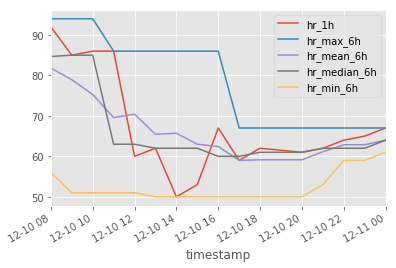

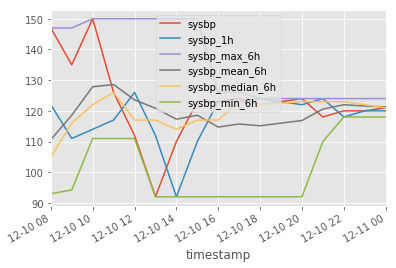

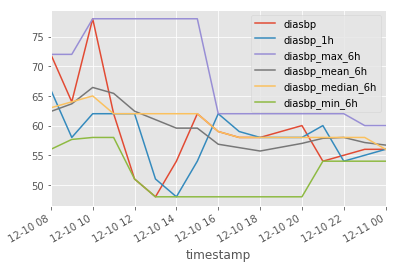

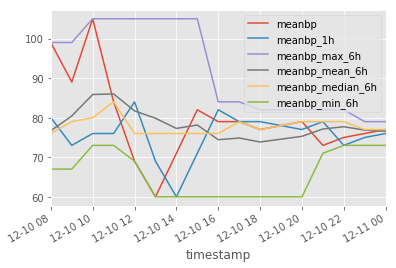

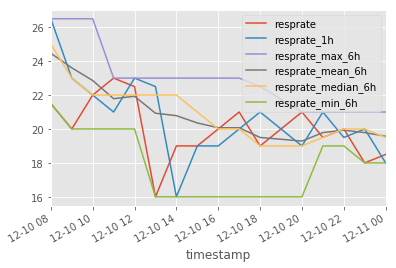

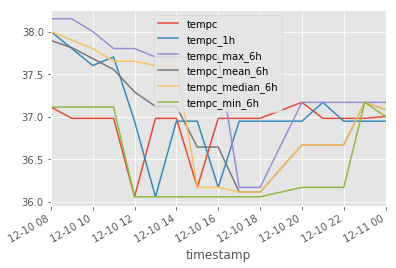

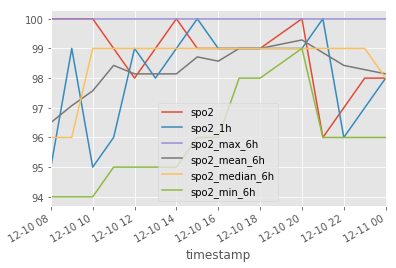

In [27]:
non_surv_rows = np.random.choice(non_survival.subject_id.values, 1)
non_survival = non_survival.loc[non_survival.subject_id.isin(non_surv_rows)]

feats = ['hr', 'sysbp', 'diasbp', 'meanbp', 'resprate', 'tempc', 'spo2']
for title, group in non_survival.groupby('subject_id'):
    for f in feats:
        group.filter(regex=f).plot()

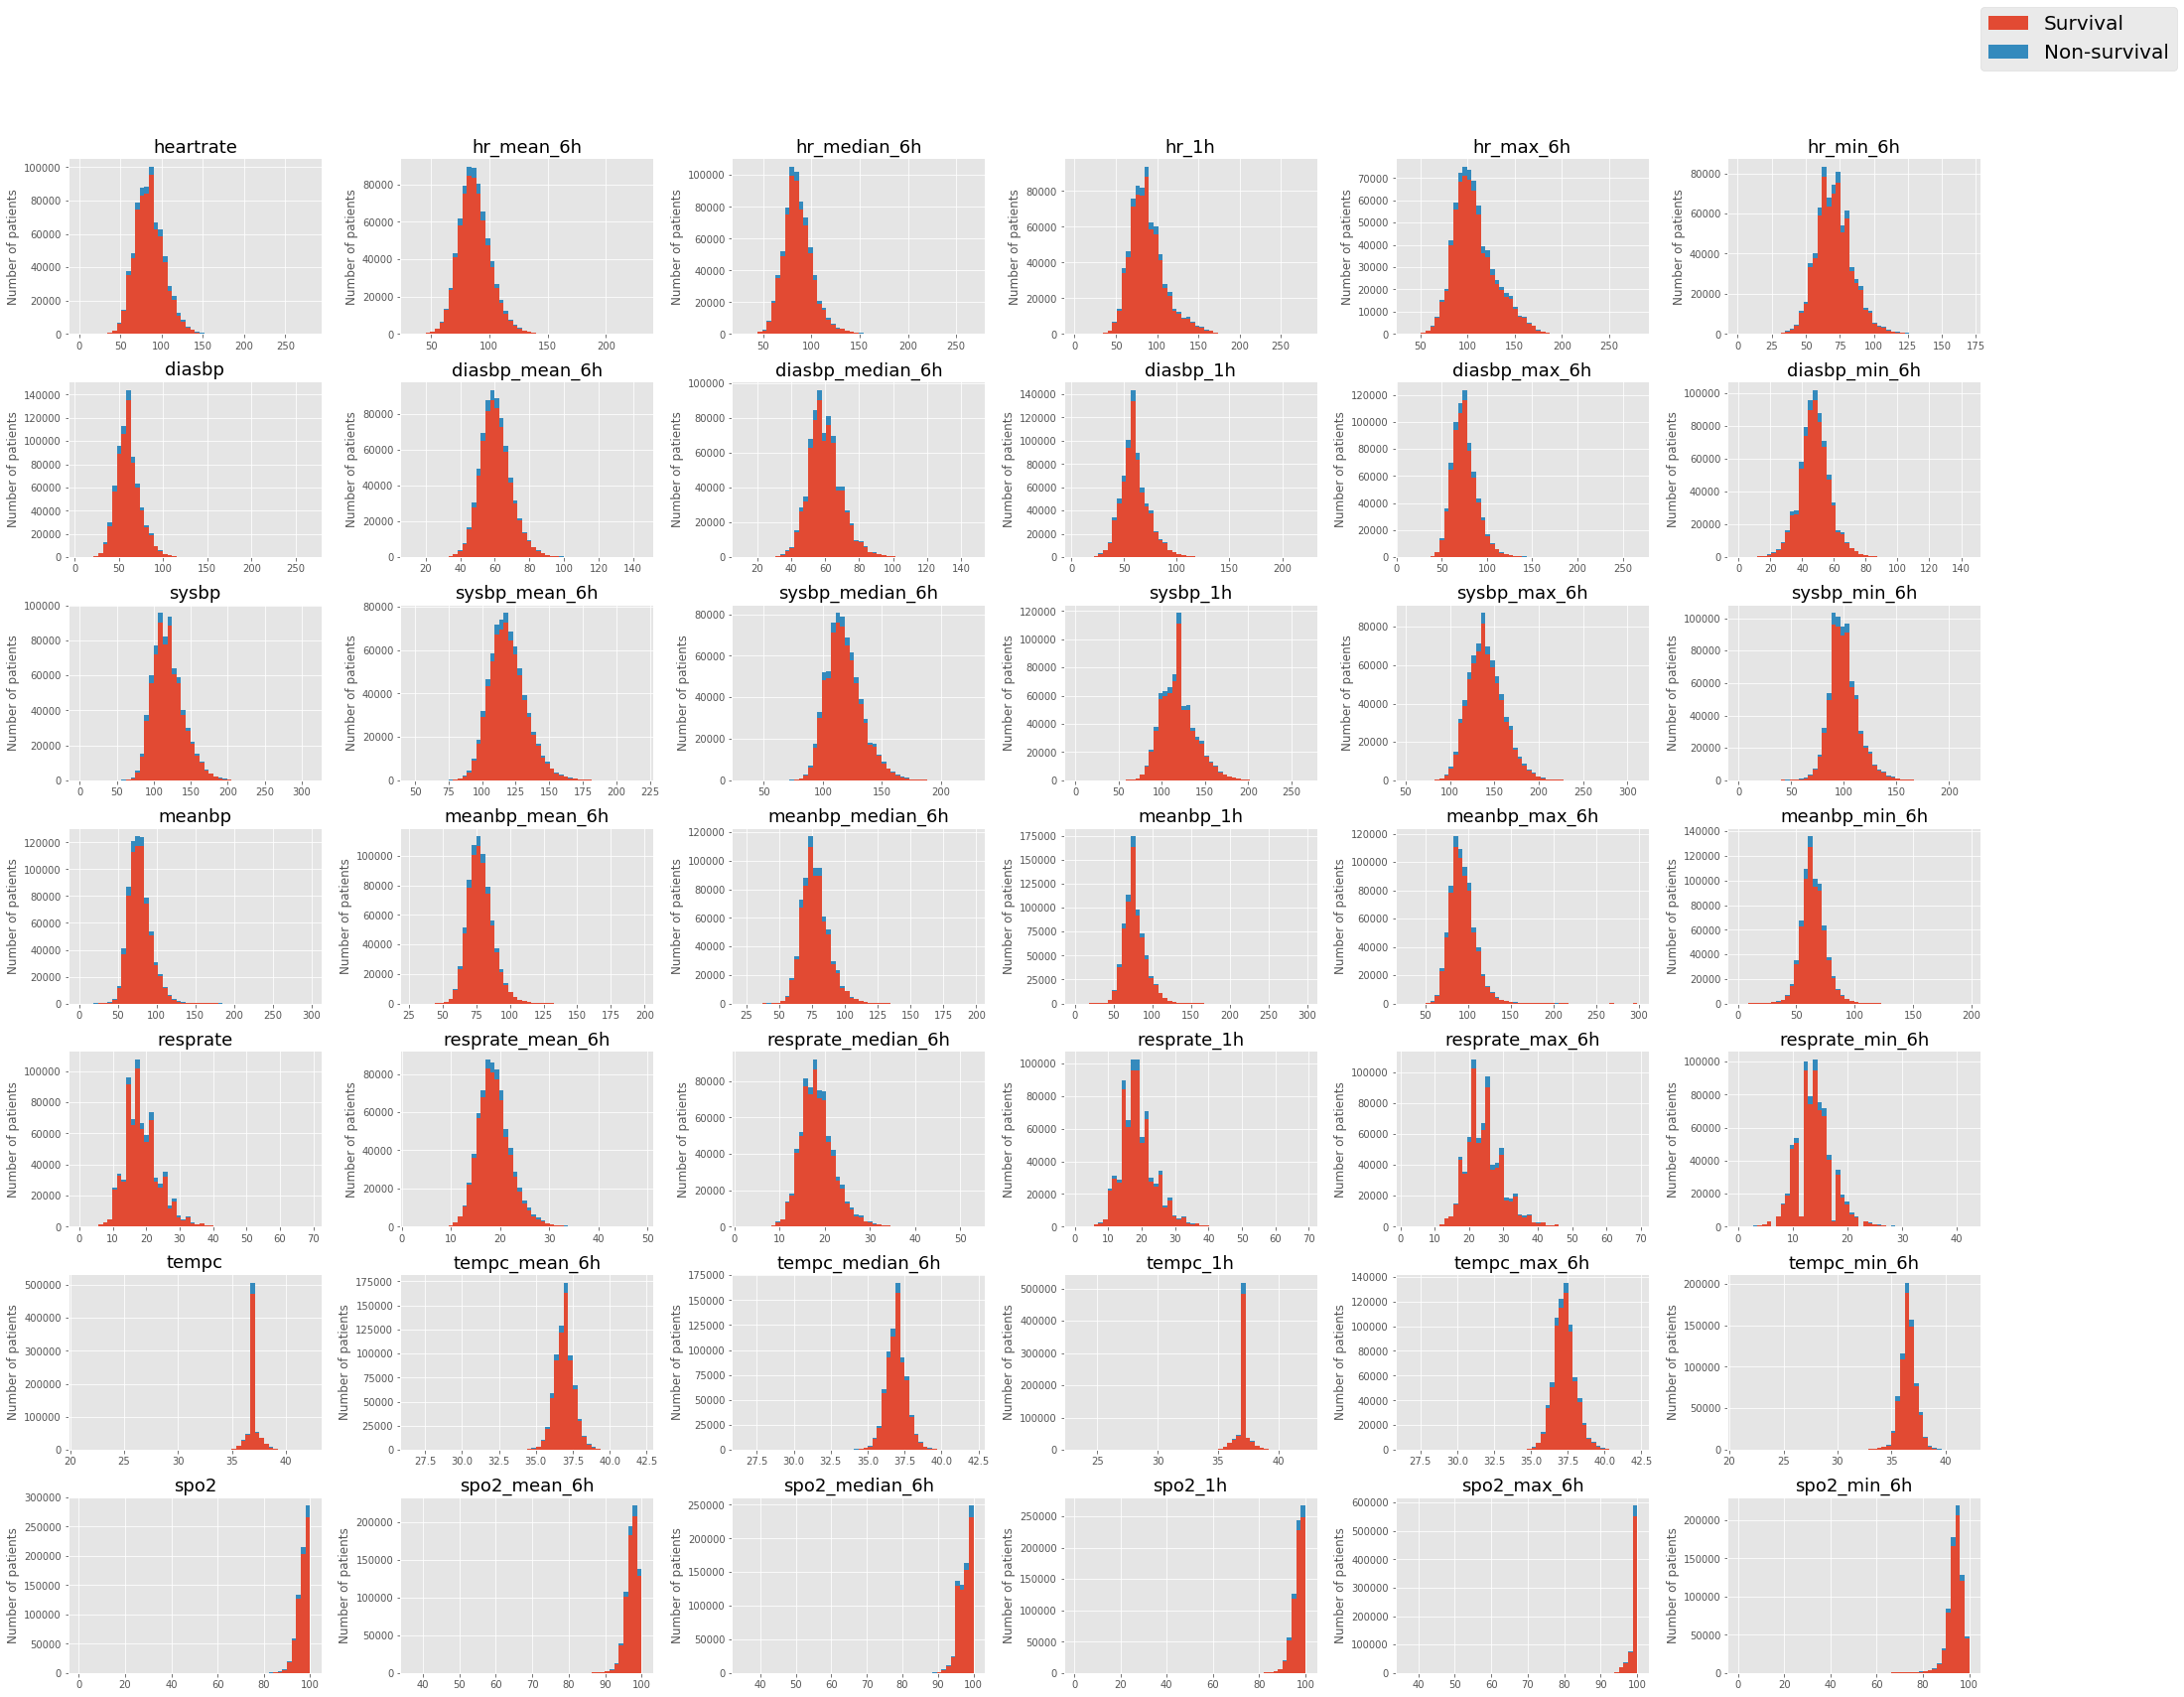

In [74]:
"""
survived = df_features.loc[df_labels.dead_in_7d == 0]
died = df_features.loc[df_labels.dead_in_7d != 0]
"""

will_die = (~query_output.dod_hosp.isnull())
died = query_output.loc[will_die]
survived = query_output.loc[~will_die]

survived = df_features.loc[df_labels.dead_in_7d == 0]
died = df_features.loc[df_labels.dead_in_7d != 0]

f, axarr = plt.subplots(7, 6, figsize=(28, 22))

i = -1
for idx, feature_name in enumerate(feature_names):
    x1 = survived.loc[:, feature_name]
    x2 = died.loc[:, feature_name]
    if idx % 6 == 0:
        i += 1
    p = axarr[i, idx % 6].hist([x1, x2], stacked=True, bins=50, normed=False)
    axarr[i, idx % 6].set_ylabel('Number of patients')
    axarr[i, idx % 6].set_title(feature_name, fontsize=18)
    
axarr[0, 5].legend(['Survival', 'Non-survival'], loc=(1, 1.5), fontsize=20)
    
plt.tight_layout()

## Data preparation

In [93]:
X = df_features.drop('subject_id', axis=1).reset_index(drop=True)
y = df_labels['dead_in_1d'].reset_index(drop=True)

dataset_size = 100000
subset_idx = np.random.choice(len(df_features), dataset_size)

X = X.loc[subset_idx].reset_index(drop=True)
y = y.loc[subset_idx].reset_index(drop=True)

split = int(len(X) * 0.5)

idx = np.random.permutation(np.arange(len(y)))
train_idx = idx[:split]
test_idx = idx[split:]

X_train = RealFeatures(np.array(X.loc[train_idx].T))
X_test = RealFeatures(np.array(X.loc[test_idx].T))

y_train = MulticlassLabels(np.array(y.loc[train_idx]).astype(np.float))
y_test = MulticlassLabels(np.array(y.loc[test_idx]).astype(np.float))

print("Number of training samples:", y_train.get_num_labels())
print("Number of testing samples:", y_test.get_num_labels())

preprocessor = PruneVarSubMean(True)
preprocessor.init(X_train)
X_train.add_preprocessor(preprocessor)
X_train.apply_preprocessor(True)

preprocessor.init(X_test)
X_test.add_preprocessor(preprocessor)
X_test.apply_preprocessor(True)

('Number of training samples:', 50000)
('Number of testing samples:', 50000)


True

In [94]:
print("Number of positive (death) labels: ", sum(y == 1))
print("Number of negative (alive) labels: ", sum(y == 0))

print("positive/negative ratio:", sum(y == 0) / float(sum(y == 1)))

('Number of positive (death) labels: ', 1455)
('Number of negative (alive) labels: ', 98545)
('positive/negative ratio:', 67.728522336769757)


## SVM

In [95]:
%%time

# Parameters to svm
C = 0.1
epsilon = 0.001

svm = LibLinear(C, X_train, y_train.get_binary_for_class(1))
svm.set_liblinear_solver_type(L2R_L2LOSS_SVC)
svm.set_epsilon(epsilon)

svm.train()

y_pred = svm.apply_binary(X_test)

#use AccuracyMeasure to get accuracy
acc = AccuracyMeasure()
acc.evaluate(y_pred, y_test.get_binary_for_class(1))

accuracy = acc.get_accuracy() * 100
print('Accuracy(%):', accuracy)

roc = ROCEvaluation()
roc.evaluate(y_pred, y_test.get_binary_for_class(1))

auc = roc.get_auROC()
print("Area under ROC(%):", auc)

('Accuracy(%):', 98.554)
('Area under ROC(%):', 0.7264790222074717)
CPU times: user 2.47 s, sys: 0 ns, total: 2.47 s
Wall time: 640 ms


In [96]:
%%time

# Parameters to svm
C = 0.1
epsilon = 0.001

svm = LibLinear(C, X_train, y_train.get_binary_for_class(1))
svm.set_liblinear_solver_type(L2R_LR)
svm.set_epsilon(epsilon)

svm.train()

y_pred = svm.apply_binary(X_test)

lr_roc = ROCEvaluation()
lr_roc.evaluate(y_pred, y_test.get_binary_for_class(1))

auc = lr_roc.get_auROC()
print("Area under ROC(%):", auc)

('Area under ROC(%):', 0.7283380194906355)
CPU times: user 2.3 s, sys: 4 ms, total: 2.3 s
Wall time: 603 ms


## Hyperparameter tuning

In [97]:
%%time

# Parameters to svm
C = 0.1
epsilon = 0.001
aucs = []
for c in [0.0, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]:
    svm = LibLinear(c, X_train, y_train.get_binary_for_class(1))
    svm.set_liblinear_solver_type(L2R_L2LOSS_SVC)
    svm.set_epsilon(epsilon)

    svm.train()

    y_pred = svm.apply_binary(X_test)

    roc = ROCEvaluation()
    roc.evaluate(y_pred, y_test.get_binary_for_class(1))

    auc = roc.get_auROC()
    aucs.append(auc)
    print(svm.get_C1(), "Area under ROC(%):", auc)

(0.0, 'Area under ROC(%):', 0.5)
(0.01, 'Area under ROC(%):', 0.7265848680916559)
(0.1, 'Area under ROC(%):', 0.7264790222074717)
(1.0, 'Area under ROC(%):', 0.7264655774505037)
(10.0, 'Area under ROC(%):', 0.7264648757408487)
(100.0, 'Area under ROC(%):', 0.7264496346071665)
(1000.0, 'Area under ROC(%):', 0.7264639214157194)
CPU times: user 15 s, sys: 84 ms, total: 15.1 s
Wall time: 3.96 s


## Random Forest

In [98]:
%%time
n_trees = 100

feature_types = np.zeros_like(X.columns, dtype=bool)
feature_types[np.where( (X.columns == 'admission_type') | (X.columns == 'first_careunit') |(X.columns == 'gender'))[0]] = True

m_vote = MeanRule()

rand_forest = RandomForest(X_train, y_train, n_trees)
rand_forest.set_combination_rule(m_vote)
rand_forest.set_feature_types(feature_types)

rand_forest.train()

y_pred = rand_forest.apply_binary(X_test)

roc = ROCEvaluation()
roc.evaluate(y_pred, y_test.get_binary_for_class(1))

auc = roc.get_auROC()
print("Area under ROC(%):", auc)

('Area under ROC(%):', 0.7935699172692738)
CPU times: user 4min 44s, sys: 1.04 s, total: 4min 45s
Wall time: 1min 27s


## Sampling 100,000 points

In [ ]:
%%time
dataset_size = 100000
n_trees = 100
feature_types = np.zeros_like(X.columns, dtype=bool)
feature_types[np.where( (X.columns == 'admission_type') | (X.columns == 'first_careunit') |(X.columns == 'gender'))[0]] = True

svm_aucs = []
lr_aucs = []
rf_aucs = []
roc = ROCEvaluation()

for i in range(10):
    
    X = df_features.drop('subject_id', axis=1).reset_index(drop=True)
    y = df_labels['dead_in_1d'].reset_index(drop=True)    
    # Randomly select 100,000 points
    subset_idx = np.random.choice(len(y), dataset_size)
    X = X.loc[subset_idx].reset_index(drop=True)
    y = y.loc[subset_idx].reset_index(drop=True)

    split = int(len(X) * 0.5)

    idx = np.random.permutation(np.arange(len(y)))
    train_idx = idx[:split]
    test_idx = idx[split:]

    X_train = RealFeatures(np.array(X.loc[train_idx].T))
    X_test = RealFeatures(np.array(X.loc[test_idx].T))

    y_train = MulticlassLabels(np.array(y.loc[train_idx]).astype(np.float))
    y_test = MulticlassLabels(np.array(y.loc[test_idx]).astype(np.float))

    preprocessor = PruneVarSubMean(True)
    preprocessor.init(X_train)
    X_train.add_preprocessor(preprocessor)
    X_train.apply_preprocessor(True)

    preprocessor.init(X_test)
    X_test.add_preprocessor(preprocessor)
    X_test.apply_preprocessor(True)    
    
    # SVM
    svm = LibLinear(C, X_train, y_train.get_binary_for_class(1))
    svm.set_liblinear_solver_type(L2R_L2LOSS_SVC)
    svm.set_epsilon(epsilon)
    svm.train()
    y_pred = svm.apply_binary(X_test)
    roc.evaluate(y_pred, y_test.get_binary_for_class(1))
    auc = roc.get_auROC()
    svm_aucs.append(auc)
    
    # Logistic regression
    svm = LibLinear(C, X_train, y_train.get_binary_for_class(1))
    svm.set_liblinear_solver_type(L2R_LR)
    svm.set_epsilon(epsilon)
    svm.train()
    y_pred = svm.apply_binary(X_test)
    roc.evaluate(y_pred, y_test.get_binary_for_class(1))
    auc = roc.get_auROC()
    lr_aucs.append(auc)
    
    # Random Forest
    feature_types = np.zeros_like(X.columns, dtype=bool)
    feature_types[np.where( (X.columns == 'admission_type') | (X.columns == 'first_careunit') |(X.columns == 'gender'))[0]] = True
    
    m_vote = MeanRule()
    rand_forest = RandomForest(X_train, y_train, n_trees)
    rand_forest.set_combination_rule(m_vote)
    rand_forest.set_feature_types(feature_types)
    rand_forest.train()
    y_pred = rand_forest.apply_binary(X_test)
    roc.evaluate(y_pred, y_test.get_binary_for_class(1))
    auc = roc.get_auROC()
    print(auc)
    rf_aucs.append(auc)

0.786942159003


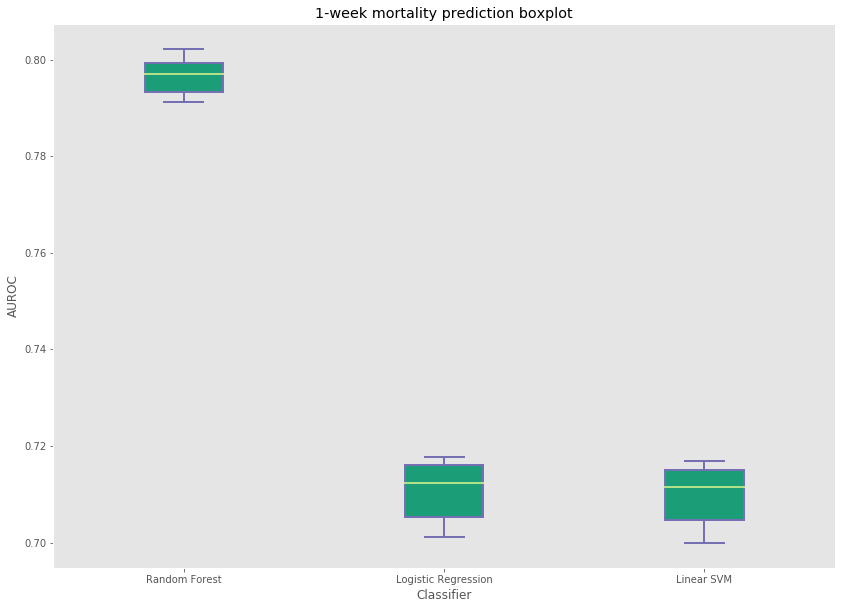

In [91]:
# styling taken from http://blog.bharatbhole.com/creating-boxplots-with-matplotlib/

aucs = [rf_aucs, lr_aucs, svm_aucs]
data = np.array(aucs).T
xlabels = [0, 1, 2] #[clf for clf in results]

plt.figure(figsize=(14, 10))
bp = plt.boxplot(data, 0, 'gD', patch_artist=True)
plt.ylabel('AUROC')
plt.xlabel('Classifier')
plt.xticks([1, 2, 3], ['Random Forest', 'Logistic Regression', 'Linear SVM'])
plt.title('1-week mortality prediction boxplot')
plt.grid(b=False)

## change outline color, fill color and linewidth of the boxes
for box in bp['boxes']:
    # change outline color
    box.set( color='#7570b3', linewidth=2)
    # change fill color
    box.set( facecolor = '#1b9e77' )

## change color and linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(color='#7570b3', linewidth=2)

## change color and linewidth of the caps
for cap in bp['caps']:
    cap.set(color='#7570b3', linewidth=2)

## change color and linewidth of the medians
for median in bp['medians']:
    median.set(color='#b2df8a', linewidth=2)

## change the style of fliers and their fill
for flier in bp['fliers']:
    flier.set(marker='o', color='#e7298a', alpha=0.5)
    
plt.show()

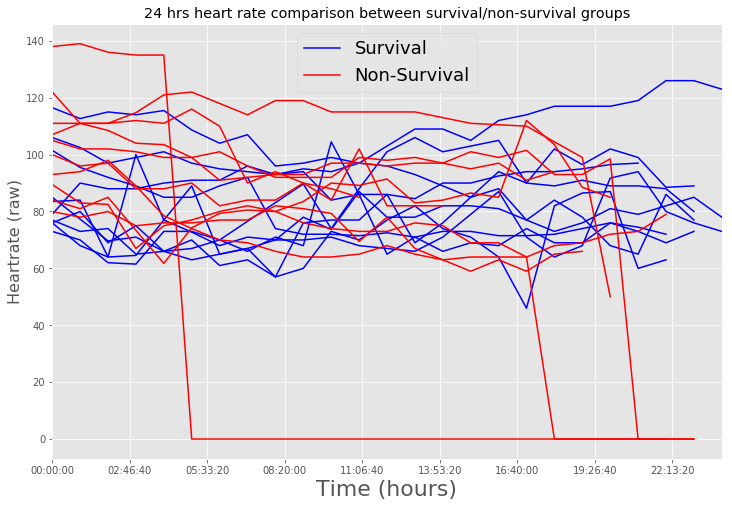

In [37]:
survival = df_features.loc[df_labels.dead_in_1d == 0]
non_survival = df_features.loc[df_labels.dead_in_1d != 0]

surv_rows = np.random.choice(survival.subject_id.values, 10)
non_surv_rows = np.random.choice(non_survival.subject_id.values, 10)

survival = survival.loc[survival.subject_id.isin(surv_rows)]
non_survival = non_survival.loc[non_survival.subject_id.isin(non_surv_rows)]

fig, ax = plt.subplots(figsize=(12, 8))

for title, group in survival.groupby('subject_id'):
    group.plot(y='heartrate', x=group.index - group.index[0], label='survival', ax=ax, color='blue')

for title, group in non_survival.groupby('subject_id'):
    death_time = pd.to_datetime(query_output[query_output.subject_id == title].dod_hosp[0])
    group.loc[group.index > death_time, 'heartrate'] = 0
    group.plot(y='heartrate', x=group.index - group.index[0], label='non-survival', ax=ax, color='red')    

legend = plt.legend(['Survival', 'Non-Survival'], fontsize=18)
legend.get_lines()[1].set_color('red')
plt.xlabel('Time (hours)', fontsize=22)
plt.ylabel('Heartrate (raw)', fontsize=16)
plt.title('24 hrs heart rate comparison between survival/non-survival groups')

plt.show()